# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from IPython.display import display
import itertools

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2024-04-27 13:45:30.959154: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 13:45:30.959245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 13:45:31.120337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Image Data Loading Function

In [2]:
def load_data(data_dir, target_size=(224, 224), batch_size=32, shuffle=True):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle 
    )
    return data_generator

# EfficientNet-B0 Model Creation Function

In [3]:
def create_model(input_shape, num_classes, learning_rate=0.001):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Model Training Function with Callbacks

In [4]:
def train_model(model, train_generator, val_generator, epochs=30):
    model_checkpoint = ModelCheckpoint("My_Efficient-B0.keras", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[model_checkpoint, reduce_lr])
    return history

# Model Evaluation Function

In [5]:
def evaluate_model(model, test_generator):
    loss, acc = model.evaluate(test_generator, verbose=0)
    print("Test Accuracy:", np.round(acc * 100, 2))
    return loss, acc


# Confusion Matrix Plotting Function

In [6]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Function for Predicting Random Image

In [7]:
def predict_random_image(model, test_generator, class_names):
    num_test_samples = len(test_generator.filenames)
    random_index = np.random.randint(0, num_test_samples)

    random_image_path = test_generator.filepaths[random_index]
    random_image = cv2.imread(random_image_path)
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    random_image = cv2.resize(random_image, (224, 224))
    random_image = random_image.astype('float32') / 255.0

    plt.imshow(random_image)
    plt.axis('off')
    plt.title("Random Image to Predict")
    plt.show()

    true_label = test_generator.filenames[random_index]
    print("Actual label:", true_label)

    prediction_prob = model.predict(np.expand_dims(random_image, axis=0))
    predicted_label_index = np.argmax(prediction_prob)
    
    class_names = list(class_names)  
    predicted_label = class_names[predicted_label_index]
    print("Predicted label:", predicted_label)

# Data Loading and Preprocessing Pipeline

In [8]:
train_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/train")
val_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/val")
test_generator = load_data("/kaggle/input/my-rice-splitted-ds/Spliited_Ds/test", shuffle=False)

Found 3261 images belonging to 4 classes.
Found 406 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


# Model Creation and Training

In [9]:
model = create_model((224, 224, 3), num_classes=len(train_generator.class_indices), learning_rate=0.001)
history = train_model(model, train_generator, val_generator)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714225892.074366     146 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714225892.180428     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/102 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.6838 - loss: 0.7429  

W0000 00:00:1714226005.194014     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7249 - loss: 0.6673

W0000 00:00:1714226041.387538     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.36453, saving model to My_Efficient-B0.keras


W0000 00:00:1714226058.706803     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


102/102 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.7255 - loss: 0.6660 - val_accuracy: 0.3645 - val_loss: 2.9557 - learning_rate: 0.0010
Epoch 2/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8778 - loss: 0.3494
Epoch 2: val_accuracy did not improve from 0.36453
102/102 ━━━━━━━━━━━━━━━━━━━━ 73s 661ms/step - accuracy: 0.8778 - loss: 0.3493 - val_accuracy: 0.3645 - val_loss: 2.4569 - learning_rate: 0.0010
Epoch 3/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.8990 - loss: 0.2984
Epoch 3: val_accuracy did not improve from 0.36453
102/102 ━━━━━━━━━━━━━━━━━━━━ 72s 661ms/step - accuracy: 0.8990 - loss: 0.2983 - val_accuracy: 0.3596 - val_loss: 1.9854 - learning_rate: 0.0010
Epoch 4/30
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 593ms/step - accuracy: 0.9213 - loss: 0.2276
Epoch 4: val_accuracy improved from 0.36453 to 0.36700, saving model to My_Efficient-B0.keras
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 680ms/step - accuracy: 0.9213 - loss: 0.2274 - val_accuracy: 0.3670 - val_los

# Save the Model

In [10]:
model.save("/kaggle/working/My_Efficient-B0.h5")


# Evaluate Model Performance on Original-Ds Test set

In [11]:
loss, acc = evaluate_model(model, test_generator)

Test Accuracy: 91.48


W0000 00:00:1714228219.164711     145 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Training History Visualization

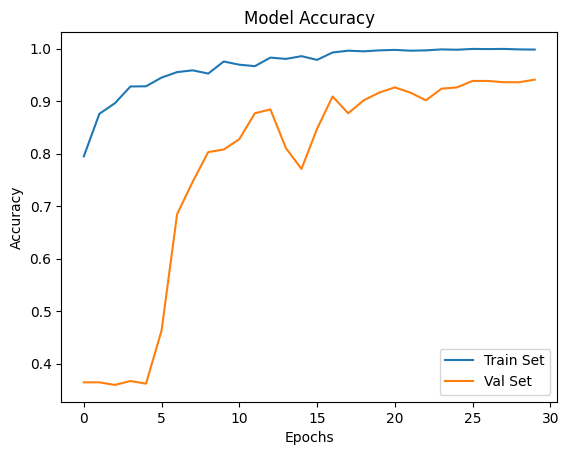

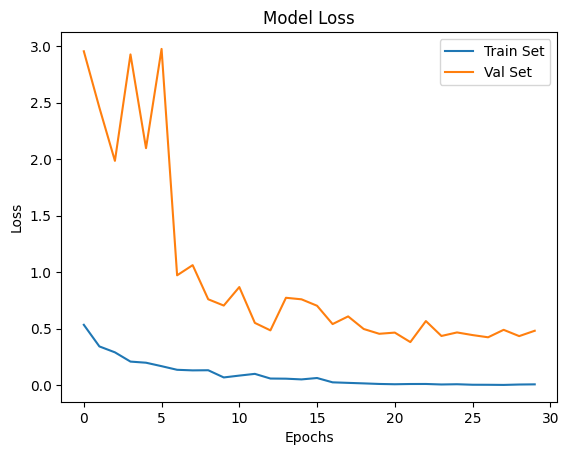

In [12]:
plt.plot(history.history['accuracy'], label='Train Set')
plt.plot(history.history['val_accuracy'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Set')
plt.plot(history.history['val_loss'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

# Evaluate Model Predictions and Metrics

In [13]:
test_pred_prob = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_prob, axis=1)
test_true_labels = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

W0000 00:00:1714228243.615764     147 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step 
                precision    recall  f1-score   support

Rice_BrownSpot       0.87      0.77      0.82        62
  Rice_Healthy       0.88      0.97      0.92       150
Rice_LeafBlast       0.91      0.84      0.87        99
Rice_NeckBlast       1.00      1.00      1.00       100

      accuracy                           0.91       411
     macro avg       0.92      0.89      0.90       411
  weighted avg       0.92      0.91      0.91       411



W0000 00:00:1714228256.461506     146 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Confusion Matrix Visualization

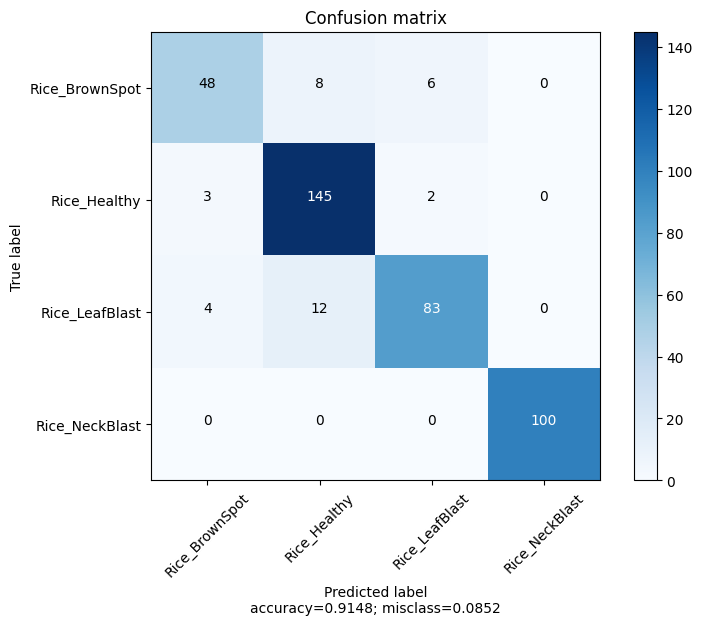

In [14]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
plot_confusion_matrix(conf_matrix, target_names=class_names)

# Additional Evaluation Metrics Calculation and Printing

In [15]:
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1_score = f1_score(test_true_labels, test_pred_labels, average='weighted')
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print evaluation measures
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Precision: 0.9153868029780439
Recall: 0.9148418491484185
F1 Score: 0.913532286640239
Sensitivity: 0.9797297297297297
Specificity: 0.8571428571428571


# Predict on a Random Image from Original-Ds

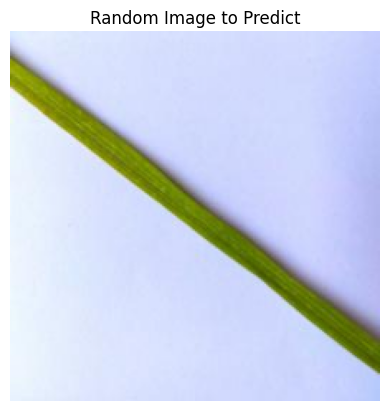

Actual label: Rice_Healthy/IMG_20190419_112033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted label: Rice_Healthy


In [16]:
predict_random_image(model, test_generator, train_generator.class_indices.keys())

# Cross-Dataset Validation

**Load and Preprocess Cross-Validation Data**

In [17]:
cross_test_generator = load_data("/kaggle/input/validation-ds/test", shuffle=False)

Found 2103 images belonging to 4 classes.


# Evaluate Performance on Cross-Validation Dataset

In [18]:
print("Accuracy on Cross Dataset:")
cross_loss, cross_acc = evaluate_model(model, cross_test_generator)

Accuracy on Cross Dataset:


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Accuracy: 85.88


W0000 00:00:1714228482.989755     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Evaluate Predictions and Metrics on Cross-Validation Dataset

In [19]:
cross_pred_prob = model.predict(cross_test_generator)
cross_pred_labels = np.argmax(cross_pred_prob, axis=1)
cross_true_labels = cross_test_generator.classes
cross_class_names = list(cross_test_generator.class_indices.keys())
print(classification_report(cross_true_labels, cross_pred_labels, target_names=cross_class_names))

66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step
              precision    recall  f1-score   support

   BrownSpot       0.90      0.87      0.88       523
     Healthy       0.93      0.67      0.78       525
   LeafBlast       0.68      0.89      0.77       524
   NeckBlast       1.00      1.00      1.00       531

    accuracy                           0.86      2103
   macro avg       0.88      0.86      0.86      2103
weighted avg       0.88      0.86      0.86      2103



W0000 00:00:1714228628.201581     148 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Confusion Matrix Visualization for Cross-Validation Dataset

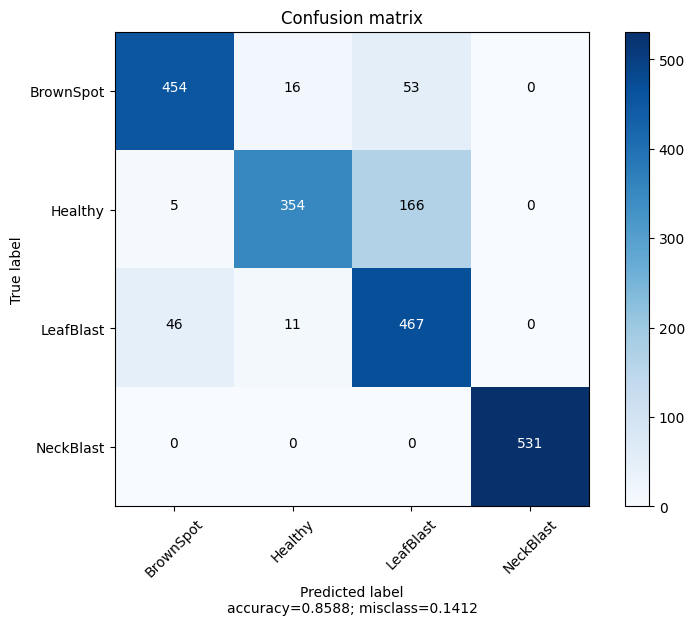

In [21]:
cross_conf_matrix = confusion_matrix(cross_true_labels, cross_pred_labels)
plot_confusion_matrix(cross_conf_matrix, target_names=cross_class_names)


# Predict on a Random Image from Cross-Validation Dataset

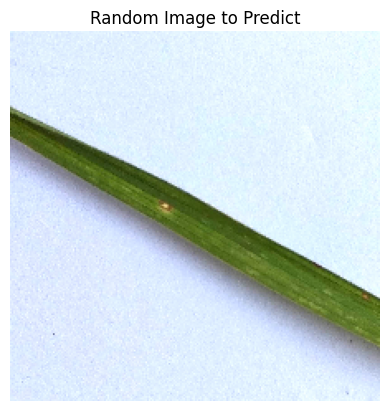

Actual label: LeafBlast/IMG_20190419_112852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted label: LeafBlast


In [23]:
# Predict on a random image from cross-validation dataset
predict_random_image(model, cross_test_generator, cross_test_generator.class_indices.keys())